### Constants extracted from data analysis

In [72]:
### CONSTANTS EXTRACTED ###

bronx_site_information=[40.929946,-73.849822,"NYSDOT-m4er5dez4ab"] 
ontario_site_information=[43.17803,-79.2853,"NYSDOT-174002"]
rochester_site_information=[43.1645,-77.683375,"Skyline-6117"]


bronx_closest_mesnet_stations=[
    {"stid": "BRON", "number": 26, "name": "Bronx", "lat": 40.872481, "lon": -73.893522, "nearest_city": "Bronx",'distance': 4.57809281205572},
    {"stid": "MANH", "number": 1, "name": "Manhattan", "lat": 40.767544, "lon": -73.964482, "nearest_city": "Manhattan",'distance': 12.715299319384322},
    {"stid": "QUEE", "number": 34, "name": "Queens", "lat": 40.734335, "lon": -73.815856, "nearest_city": "Queens",'distance': 13.614767690920887}
 ]


ontario_closest_mesnet_stations=[
    {'stid': 'BURT', 'number': 119, 'name': 'Burt', 'lat': 43.31699, 'lon': -78.74903, 'nearest_city': 'Burt', 'distance': 28.711829547809472},
    {'stid': 'BUFF', 'number': 4, 'name': 'Buffalo', 'lat': 43.00017, 'lon': -78.76717, 'nearest_city': 'Buffalo','distance':28.946973186909712}, 
    {'stid': 'BRAN', 'number': 66, 'name': 'Brant', 'lat': 42.59494, 'lon': -79.02154, 'nearest_city': 'Brant','distnace': 42.41808812950842}
]


rochester_closest_mesnet_stations=[
    {'stid': 'RUSH',
   'number': 87,
   'name': 'Rush',
   'lat': 43.00099,
   'lon': -77.63739,
   'nearest_city': 'Rush',
   'distance': 11.524563897670545
   },
 {'stid': 'BROC',
   'number': 43,
   'name': 'Brockport',
   'lat': 43.20835,
   'lon': -77.96592,
   'nearest_city': 'Brockport',
   'distance': 14.589877726693853
  },
 {'stid': 'ONTA',
   'number': 37,
   'name': 'Ontario',
   'lat': 43.25941,
   'lon': -77.37331,
   'nearest_city': 'Ontario',
   'distance': 16.97166469039402
  }
  ]


stid_to_closest = {
      'NYSDOT_m4er5dez4a': bronx_closest_mesnet_stations,
      'NYSDOT-174002': ontario_closest_mesnet_stations,
      'Skyline-6117': rochester_closest_mesnet_stations
  }


first_bronx_dry_image= 'NYSDOT_m4er5dez4ab_2022-01-26-00-01-07.jpg'
last_bronx_dry_image='NYSDOT_uyomtjhwsay_2022-03-16-23-31-04.jpg'


path_prefix = 'C:/Users/al105/OneDrive/Desktop/OU/Research/'
classes = ['dry', 'snow', 'wet']
sites = [
         'bronx_fix/bronx_allsites', 
         'rochester_fix/rochester_allsites', 
         'ontario_fix/ontario_allsites'
         ]

## Imports (Run First)

In [2]:
import pandas as pd
import geopy.distance
import re
import os

# json in standard library to dump and format into datastrucutre in Overleaf
import json

from datetime import datetime, timezone

import xarray as xr
from glob import glob
import numpy as np

In [3]:
ny_mesonet_df=pd.read_csv('./data/nysm.csv')

f= open('./data/nysm.csv', 'r')
lines=f.readlines()
f.close()

num_lines=len(lines)

all_stations=[]

for i in range(1,num_lines):
    curr_line=lines[i]
    elements=curr_line.split(',')
    current_station={
        "stid": elements[0],
        "number": int(elements[1]),
        "name": elements[2],
        "lat": float(elements[3]),
        "lon": float(elements[4]),
        "nearest_city": elements[7]
        # "distance": float("inf")
        }
    all_stations.append(current_station)

def index(arr):
    return list(range(len(arr)))
    
station_names = [i['stid'] for i in all_stations]
names_numbers = {station_names[i]: i for i in index(station_names)}
numbers_names = {i : station_names[i] for i in index(station_names)}

## Utility Functions for Data Preprocessing

In [4]:
def find_closest_mes_station(all_stations, camera_coordinates, n=3):

    k_closest=[] # how ever many Mesnet stations you want

    for station in all_stations:
        camera_latlon=(camera_coordinates[0],camera_coordinates[1])
        nysm_latlon = (station["lat"], station["lon"])
        # print(nysm_latlon)
        #print(type(station))

        distance=geopy.distance.geodesic(nysm_latlon, camera_latlon).miles
        
        k_closest.append((station,distance))

    my_list = sorted(k_closest,key=lambda k: k[-1])[:n]
    return my_list


def unix_time_seconds(dt):
    """
    :param dt: datetime object
    :@ return: unix time (seconds since the epoch GMT)
    """
    epoch = datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds()


  # helper function to parse the string and recognize the regex whatever date-format you have
def get_timestamp(your_path:str):
    data=re.compile(r'[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])-(2[0-3]|[01][0-9])-[0-5][0-9]-[0-5][0-9]')
    found_date_format=str(data.search(your_path).group()) 
    return unix_time_seconds(datetime.strptime(found_date_format,'%Y-%m-%d-%H-%M-%S'))

# Use this function to get a list of the timestamps for a list of image-paths
def getTimeStamps(path_list:list):
    a=[]
    for row in path_list:
        ts=get_timestamp(row)
        a.append(ts)
    return sorted(a)


def getTimestamp_path_tuples(path_list:list):
    a=[]
    for row in path_list:
        ts=get_timestamp(row)
        a.append((ts, row))
    return sorted(a, key=lambda k: k[0])


# pretty print dictionaries
def dict_to_string(d: dict, prefix="\t"):
    """
    :param d: (dict) a dictionary
    :param prefix: (string) prefix to append to delinneate different levels
                   of dict hierarchy 
    """
    # print each key/value pair from the dict on a new line
    s = "{\n"
    for k in d:
        if isinstance(d[k], dict):
            newfix = prefix + '\t'
            s += f"{prefix}{k}: {dict_to_string(d[k], newfix)}\n"
        else:
            s += f"{prefix}{k}: {d[k]}\n"
    return s + prefix + "}"


def pathToTime(path):
    format_data=re.compile(r'[0-9]{4}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])-(2[0-3]|[01][0-9])-[0-5][0-9]-[0-5][0-9]') # current format from the .jpg file 
    found_date_format_data = str(format_data.search(path).group()) 
    path_dateTimeObject=datetime.strptime(found_date_format_data,'%Y-%m-%d-%H-%M-%S')
    
    return unix_time_seconds(path_dateTimeObject)


def retrieve_mesonet_data(nysm_id: str, nysm_path='/ourdisk/hpc/ai2es/datasets/auto_archive_notyet/', years=('2020', '2021', '2022', '2023')):
    ''' 
    Retreives all mesonet data for a particular station. 
    
    The mesonet data is stored in nc files. These are extracted, converted to 
    dataframes, then filtered for the target station.
    
    Args:
        nysm_id: NYSM station ID of the station
        mesonet_path: path to the mesonet nc files.
        
    Returns:
        a pd.DataFrame of all the mesonet data for the provided station.
    '''
    
    mesonet_path = os.path.join(nysm_path, 'NYSM/archive/nysm/netcdf/proc/')
    
    # Build empty dataframe to append mesonet data to.
    mesonet_df = pd.DataFrame()
    
    # Loop through all years in the dataset.
    for year_dir in glob(os.path.join(mesonet_path, '*')):
        
        if os.path.basename(year_dir) not in years:
            break
        
        # Loop through all months in the year.
        for month_dir in glob(os.path.join(year_dir, '*')):
            
            # Grab all the days in the month.
            for day_file in glob(f'{month_dir}/*.nc'):
                
                # Open the nc file and convert to dataframe.
                day_df = xr.open_dataset(f'{day_file}').to_dataframe()

                # Filter for target station.
                day_df = day_df.reset_index()
                station_df = day_df[day_df['station'] == nysm_id]
                
                # station_df = day_df.loc[nysm_id].reset_index()
                
                # Add this to our dataframe.
                mesonet_df = pd.concat([mesonet_df, station_df])
    
    return mesonet_df.sort_values(by='time_5M')


def retrieve_mesonet_data_allstations(nysm_ids, nysm_path='/ourdisk/hpc/ai2es/datasets/auto_archive_notyet/', years=('2020', '2021', '2022', '2023')):
    ''' 
    Retreives all mesonet data for a particular station. 
    
    The mesonet data is stored in nc files. These are extracted, converted to 
    dataframes, then filtered for the target station.
    
    Args:
        nysm_id: NYSM station ID of the station
        mesonet_path: path to the mesonet nc files.
        
    Returns:
        a pd.DataFrame of all the mesonet data for the provided station.
    '''
    
    mesonet_path = os.path.join(nysm_path, 'NYSM/archive/nysm/netcdf/proc/')
    
    # Build empty dataframe dict to append mesonet data to.
    
    mesonet_dfs = {
        nysm_id: pd.DataFrame() for nysm_id in nysm_ids
    }
    
    # Loop through all years in the dataset.
    for year_dir in glob(os.path.join(mesonet_path, '*')):
        
        if os.path.basename(year_dir) not in years:
            break
        
        # Loop through all months in the year.
        for month_dir in glob(os.path.join(year_dir, '*')):
            
            # Grab all the days in the month.
            for day_file in glob(f'{month_dir}/*.nc'):
                
                # Open the nc file and convert to dataframe.
                day_df = xr.open_dataset(f'{day_file}').to_dataframe()

                # Filter for target station.
                day_df = day_df.reset_index()
                for nysm_id in mesonet_dfs:
                    print(nysm_id, end='\r')
                    station_df = day_df[day_df['station'] == nysm_id]

                    # station_df = day_df.loc[nysm_id].reset_index()

                    # Add this to our dataframe.
                    mesonet_dfs[nysm_id] = pd.concat([mesonet_dfs[nysm_id], station_df])
    
    return {nysm_id: mesonet_dfs[nysm_id].sort_values(by='time_5M') for nysm_id in mesonet_dfs}

### Code for nearest Mesnet station

In [5]:
# load the data
df_dict = retrieve_mesonet_data_allstations(station_names)

In [7]:
df_dict[numbers_names[0]].columns

Index(['station', 'time_5M', 'lat', 'lon', 'elev', 'tair', 'ta9m', 'tslo',
       'relh', 'srad', 'pres', 'wspd_sonic', 'wmax_sonic', 'wssd_sonic',
       'wdir_sonic', 'wdsd_sonic', 'wspd_prop', 'wmax_prop', 'wssd_prop',
       'wdir_prop', 'wdsd_prop', 'wspd_merge', 'wmax_merge', 'wssd_merge',
       'wdir_merge', 'wdsd_merge', 'precip', 'precip_total',
       'precip_max_intensity', 'ts05', 'ts25', 'ts50', 'sm05', 'sm25', 'sm50',
       'frozen05', 'frozen25', 'frozen50', 'snow_depth'],
      dtype='object')

In [88]:
numpy_tensors = []
drop_stations = []
station_order = []
station_latlon = {}

for i in numbers_names:
    print(i, 'of', len(numbers_names), ':', numbers_names[i])
    df = df_dict[numbers_names[i]]
    station_latlon[numbers_names[i]] = (df['lat'].iloc[0], df['lon'].iloc[0])
    df = df.drop(['station', 'snow_depth', 'ts05', 'ts25', 'ts50', 'sm05', 'sm25', 'sm50', 'frozen05', 'frozen25', 'frozen50', 'time_5M'], axis=1)
    df.interpolate(limit=24, limit_area='inside', limit_direction='both', inplace=True)
    nas_per_col = max([(col, df[col].isna().sum()) for col in df.columns], key=lambda k: k[-1])
    if nas_per_col[-1] / len(df['lat']) > .25:
        print(nas_per_col)
        drop_stations.append(numbers_names[i])
        continue
    station_order.append(numbers_names[i])
    # df.sort_values('time_5M', inplace=True)
    numpy_tensors.append(df.to_numpy(copy=True))

numpy_tensor = np.stack(numpy_tensors, 0)
print(numpy_tensor.shape)

0 of 126 : ADDI
1 of 126 : ANDE
2 of 126 : BATA
3 of 126 : BEAC
4 of 126 : BELD
5 of 126 : BELL
6 of 126 : BELM
7 of 126 : BERK
8 of 126 : BING
9 of 126 : BKLN
10 of 126 : BRAN
11 of 126 : BREW
12 of 126 : BROC
13 of 126 : BRON
14 of 126 : BROO
15 of 126 : BSPA
16 of 126 : BUFF
17 of 126 : BURD
18 of 126 : BURT
19 of 126 : CAMD
20 of 126 : CAPE
21 of 126 : CHAZ
22 of 126 : CHES
23 of 126 : CINC
24 of 126 : CLAR
25 of 126 : CLIF
26 of 126 : CLYM
27 of 126 : COBL
28 of 126 : COHO
29 of 126 : COLD
30 of 126 : COPA
31 of 126 : COPE
32 of 126 : CROG
33 of 126 : CSQR
34 of 126 : DELE
35 of 126 : DEPO
36 of 126 : DOVE
37 of 126 : DUAN
38 of 126 : EAUR
39 of 126 : EDIN
40 of 126 : EDWA
41 of 126 : ELDR
42 of 126 : ELLE
43 of 126 : ELMI
44 of 126 : ESSX
45 of 126 : FAYE
46 of 126 : FRED
47 of 126 : GABR
48 of 126 : GFAL
49 of 126 : GFLD
50 of 126 : GROT
51 of 126 : GROV
52 of 126 : HAMM
53 of 126 : HARP
54 of 126 : HARR
55 of 126 : HART
56 of 126 : HERK
57 of 126 : HFAL
58 of 126 : ILAK
59 of 1

In [89]:
nan_instants = []
print(len(np.argwhere(np.isnan(numpy_tensor))))
for i in range(numpy_tensor.shape[1]):
    if np.isnan(numpy_tensor[:, i, :]).any():
        nan_instants.append(i)
print(len(nan_instants))
with_nan_removed = np.delete(numpy_tensor, nan_instants, axis=1)
with_nan_removed.shape

2324647
117037


(124, 6515, 27)

In [92]:
# distance table
new_names_numbers = {name for name in station_order}

new_numbers_names = {i : station_order[i] for i in index(station_order)}

distances = np.full((len(station_order), len(station_order)), float('inf'))
for i in new_numbers_names:
    this_latlon = station_latlon[new_numbers_names[i]]
    for j in new_numbers_names:
        if i != j: 
            that_latlon = station_latlon[new_numbers_names[j]]
            distances[i][j] = geopy.distance.geodesic(this_latlon, that_latlon).miles
            if distances[i][j] == 0:
                print(this_latlon, new_numbers_names[i], that_latlon, new_numbers_names[j])

# max distance such that every station has at least three neighbors
k_max_distance = np.sort(distances, 0)[:3].max()
distances = np.where(distances > k_max_distance, np.full_like(distances, float('inf')), distances)
weights = 1 / distances
weights
k_max_distance

60.63860487131321

In [ ]:
np.save('./data/distance_weights', weights)
np.save('./data/nanless_station_times', with_nan_removed)

In [2]:
import torch
# Numpy for matrices
# https://mlabonne.github.io/blog/intrognn/
# https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import networkx as nx

/home/fagg/miniconda3/envs/tf_bleeding5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
loaded = np.load('./data/nanless_station_times.npy')
dataset = np.transpose(loaded, [1, 0, 2])
edges = np.load('./data/distance_weights.npy')
edges_no_weights = np.transpose(np.argwhere(edges > 0))
# TODO: convert these edges into an adjacency list
argwhere = np.argwhere(edges > 0)
edge_weights = [edges[argwhere[i][0], argwhere[i][1]] for i in range(argwhere.shape[0])]
print(dataset.shape, edges_no_weights.shape, np.array(edge_weights))

(11699, 117, 27) (2, 2342) [0.01770202 0.02859934 0.0293081  ... 0.01962127 0.01901466 0.01752678]


In [46]:
import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Data
# https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8

class MesonetGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MesonetGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    
    @property
    def processed_file_names(self):
        return ['../data/MesonetGraphDataset.dataset']

    def download(self):
        pass
    
    def process(self):
        # load the data from the numpy files
        loaded = np.load('./data/nanless_station_times.npy')
        edges = np.load('./data/distance_weights.npy')
        # convert the dataset into samples, nodes, features 
        dataset = np.transpose(loaded, [1, 0, 2])
        # get the edges
        edges_no_weights = np.transpose(np.argwhere(edges > 0))
        # get the edge weights
        argwhere = np.argwhere(edges > 0)
        edge_weights = [edges[argwhere[i][0], argwhere[i][1]] for i in range(argwhere.shape[0])]
        
        data_list = []

        # for each graph state that we have
        for i in range(dataset.shape[0]):
            edge_index = torch.tensor(edges_no_weights, dtype=torch.int64)
            node_features = torch.tensor(dataset[i], dtype=torch.float32)
            masked_entry = dataset[i]
            masked_entry[np.random.choice(np.arange(dataset[i].shape[0]))] *= 0.0
            node_features_masked = torch.tensor(masked_entry, dtype=torch.float32)
            edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
            
            data = Data(node_features=node_features_masked, edge_index=edge_index, edge_weights=edge_weights, y=node_features)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [64]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GraphConv

# dataset, edges_no_weights, edge_weights

class GCN(torch.nn.Module):
    def __init__(self, n_features):
        super(GCN, self).__init__()
        self.gc0 = GraphConv(-1, n_features)
        self.gc1 = GraphConv(n_features, 32)
        self.gc2 = GraphConv(32, 32)
        self.gc3 = GraphConv(32, n_features)

    def forward(self, data):
        x = self.gc0(data.node_features, data.edge_index, data.edge_weights)
        x = self.gc1(x, data.edge_index, data.edge_weights).relu()
        x = self.gc2(x, data.edge_index, data.edge_weights).relu()
        x = self.gc3(x, data.edge_index, data.edge_weights)
        return x

model = GCN(27)
print(model)

GCN(
  (gc0): GraphConv(-1, 27)
  (gc1): GraphConv(27, 32)
  (gc2): GraphConv(32, 32)
  (gc3): GraphConv(32, 27)
)


tensor([[  0,   6],
        [  0,  16],
        [  0,  27],
        ...,
        [116, 102],
        [116, 108],
        [116, 115]])


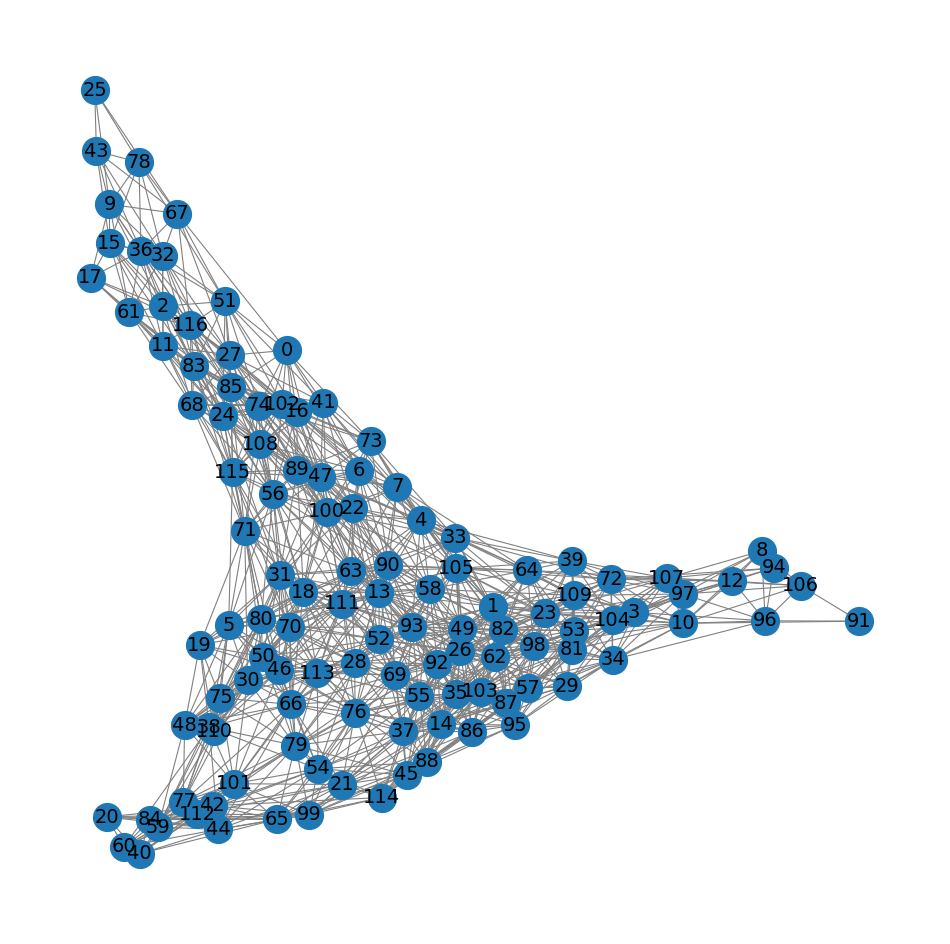

In [65]:
dataset = MesonetGraphDataset('./')
dataset = dataset.shuffle()
train_dataset = dataset[:8000]
test_dataset = dataset[8000:]
print(torch.transpose(test_dataset[0].edge_index, 0, 1))

from torch_geometric.utils import to_networkx

G = to_networkx(test_dataset[0], to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=400,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )

#G = nx.from_edgelist(torch.transpose(test_dataset[0].edge_index, 0, 1))
#nx.draw_networkx(G)

In [66]:
from torch_geometric.data import DataLoader
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
        
    return loss_all / len(train_dataset)

device = torch.device('cuda')
model = GCN(27)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.MSELoss()
train_loader = DataLoader(train_dataset, batch_size=32)

for epoch in range(20):
    print(epoch, train())

0 3082.2680468139647
1 119.25997940063476
2 74.73462376403809
3 61.04990530395508
4 51.56062559509277
5 45.486709197998046
6 41.95881304168701
7 40.274533073425296
8 38.87176908111572
9 35.53011514282227
10 36.32979267120361
11 37.12678330230713
12 35.512782424926755
13 35.78018734741211
14 34.79801844024658
15 34.41959558868408
16 33.67883870697022
17 34.6099935760498
18 28.72491690826416
19 33.43621578979492
